In [1]:
import gc
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

import scipy.stats as st
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.decomposition import PCA

import helpers as hp

In [2]:
MDIR = '/sanssauvegarde/homes/v18porti/info/'

In [3]:
df_ALL = pd.read_feather(MDIR + '200_32.feather')

In [4]:
"""dfgb = df_ALL.groupby('vectorUFAmpKLD_ALL')['vectorUFAmpKLD_ALL'].nunique()
print(dfgb)"""

"dfgb = df_ALL.groupby('vectorUFAmpKLD_ALL')['vectorUFAmpKLD_ALL'].nunique()\nprint(dfgb)"

In [5]:
df_ALL.describe()

,vectorRRKLD_ALL,vectorFAmpKLD_ALL,vectorUFAmpKLD_ALL,vectorCorrKLD_ALL
count,5.035840e+07,5.035947e+07,5.035947e+07,4.943770e+07
mean,2.868624e+14,1.002450e+02,1.832059e+14,1.364339e+01
std,inf,3.779417e+03,inf,3.970723e+01
min,-1.196758e+01,0.000000e+00,-1.520206e+00,0.000000e+00
25%,8.376141e+00,3.713027e+00,1.080568e+01,4.991102e+00
50%,1.086889e+01,5.205714e+00,1.434603e+01,7.447418e+00
75%,1.583047e+01,7.720136e+00,2.120557e+01,1.173964e+01
max,3.421422e+19,8.780618e+05,2.250281e+20,1.712306e+03


>200 - 921773/50358400 = 1.83% null values (for most unfavorable feature vectorCorrKLD_ALL)

>300 - 1377982/81318210 = 1.7% null values (for most unfavorable feature vectorCorrKLD_ALL)

In [6]:
len(df_ALL) - df_ALL.count()

vectorRRKLD_ALL         1069
vectorFAmpKLD_ALL          0
vectorUFAmpKLD_ALL         0
vectorCorrKLD_ALL     921773
dtype: int64

In [7]:
X = df_ALL.to_numpy()

In [8]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(X)
X = imp_mean.transform(X)

In [9]:
df_ALL = hp.convertDictInDF(hp.putDataInDict(
        [X[:,0], X[:,1], X[:,2], X[:,3]],
        ['vectorRRKLD', 'vectorFAmpKLD', 'vectorUFAmpKLD', 'vectorCorrKLD']
    ))
#['vectorRRKLD', 'vectorFAmpKLD', 'vectorUFAmpKLD', 'vectorCorrKLD']

In [10]:
df_ALL.describe()

,vectorRRKLD,vectorFAmpKLD,vectorUFAmpKLD,vectorCorrKLD
count,5.035947e+07,5.035947e+07,5.035947e+07,5.035947e+07
mean,2.868624e+14,1.002450e+02,1.832059e+14,1.364339e+01
std,inf,3.779417e+03,inf,3.934215e+01
min,-1.196758e+01,0.000000e+00,-1.520206e+00,0.000000e+00
25%,8.376195e+00,3.713027e+00,1.080568e+01,5.036375e+00
50%,1.086902e+01,5.205714e+00,1.434603e+01,7.554125e+00
75%,1.583089e+01,7.720136e+00,2.120557e+01,1.215418e+01
max,3.421422e+19,8.780618e+05,2.250281e+20,1.712306e+03


In [ ]:
"""stat, p = st.normaltest(X)"""

> From description, we can see that "vectorRRKLD" and "vectorUFAmpKLD" have a strange behavior (inf std dev??)

# Take out outliers 

## Zscore 

> Tried other statistical methods (listed below) but got not conclusive results (the ouliers I wanted to be removed weren't) and the complexity was too high for some (KNN) so time and memory were an issue
```python
from sklearn.neighbors import LocalOutlierFactor
from pyod.models.hbos import HBOS # Histogram-based Outlier Detection
from pyod.models.knn import KNN # K Nearest Neighbors
```


In [11]:
df_1 = df_ALL

In [12]:
threshold = 10

In [12]:
print(np.abs(st.zscore(df_1['vectorRRKLD'])))
print(np.abs(st.zscore(df_1['vectorFAmpKLD'])))
print(np.abs(st.zscore(df_1['vectorUFAmpKLD'])))
print(np.abs(st.zscore(df_1['vectorCorrKLD'])))

/homes/v18porti/.local/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/homes/v18porti/.local/lib/python3.6/site-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


[0. 0. 0. ... 0. 0. 0.]
[0.03516507 0.03523961 0.03523359 ... 0.03529376 0.03529376 0.03539162]
[0. 0. 0. ... 0. 0. 0.]
[0.34297556 0.34216455 0.34216455 ... 0.29440117 0.29440117 0.32050768]


## HARD REMOVE 
(Columns showing resistence to statistical removal: vectorUFAmpKLD, vectorRRKLD)

> Used 2e+2 as manual limit for both vectorUFAmpKLD and 0.5e+2 vectorRRKLD

>Just deleted this way maximum 95% of the data (for 200 patients && 300)

### vectorUFAmpKLD

In [17]:
df_2 = df_1.copy()
df_2 = df_1[(df_1['vectorUFAmpKLD'] < 5e+10)]
print(df_1.shape)
print(df_2.shape)
print(100*df_2.shape[0]/df_1.shape[0])

(81320065, 4)
(77762533, 4)
95.62527157350404


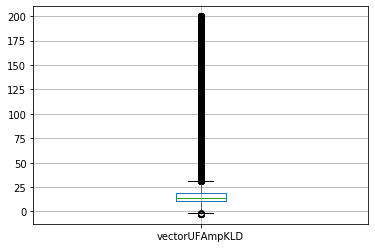

In [18]:
df_2.boxplot('vectorUFAmpKLD') # 300

> Now, the distribution is more obvious

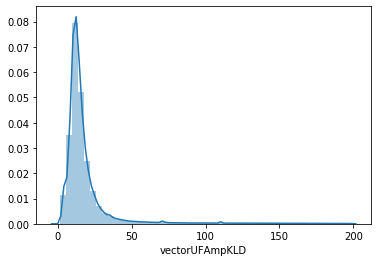

In [20]:
sns.distplot(df_2['vectorUFAmpKLD']) # 300

> just after removal, zscore is now available

In [19]:
np.abs(st.zscore(df_2['vectorUFAmpKLD']))
print(max(np.abs(st.zscore(df_2['vectorUFAmpKLD']))))

8.202746


### vectorRRKLD

In [21]:
df_2 = df_1.copy()
df_2 = df_1[(df_1['vectorRRKLD'] < 0.5e+2)]
print(df_1.shape)
print(df_2.shape)
print(100*df_2.shape[0]/df_1.shape[0])

(81320065, 4)
(79528675, 4)
97.79711194279051


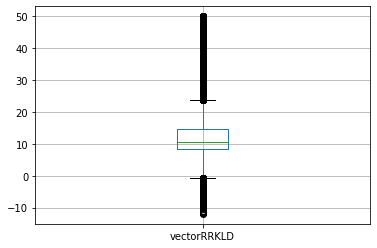

In [22]:
df_2.boxplot('vectorRRKLD') # 300

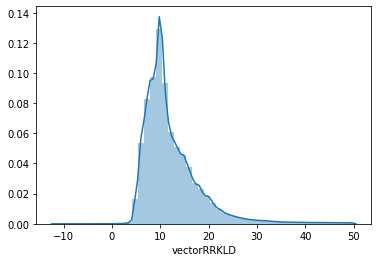

In [24]:
sns.distplot(df_2['vectorRRKLD']) # 300

In [23]:
print(np.abs(st.zscore(df_2['vectorRRKLD'])))
print(max(np.abs(st.zscore(df_2['vectorRRKLD']))))

[0.41320977 0.46862367 0.4463541  ... 0.56082994 0.56082994 0.55804116]
6.1892967


## Soft Remove

### vectorFAmpKLD 
> threshold 100, 50, 10, 2 ≈ 99 %

In [20]:
threshold = 2

In [21]:
df_2 = df_1.copy()
z = np.abs(st.zscore(df_2['vectorFAmpKLD']))
print(max( z ))
print(np.where(z > threshold))

288.5417
(array([  408614,   408615,   408616, ..., 78151875, 78151876, 78151877]),)


In [22]:
df_2 = df_2[(z <= threshold)]
print(df_1.shape)
print(df_2.shape)
print(100*df_2.shape[0]/df_1.shape[0])

(81320065, 4)
(81037471, 4)
99.65249166979883


> BEFORE / AFTER

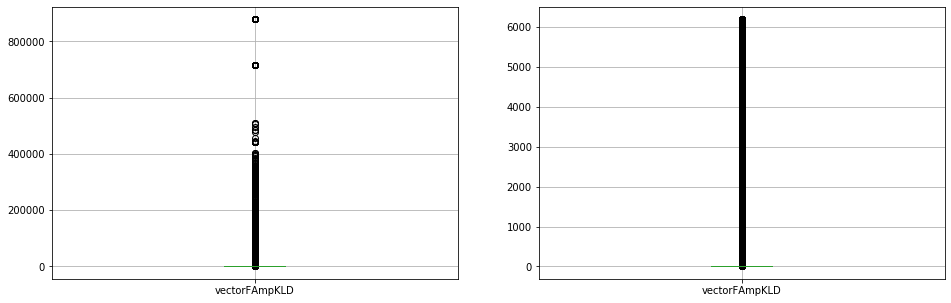

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5)) # 300
df_ALL.boxplot(column='vectorFAmpKLD', ax=ax[0])
df_2.boxplot(column='vectorFAmpKLD', ax=ax[1])
plt.show(); fig.clf(); plt.close()

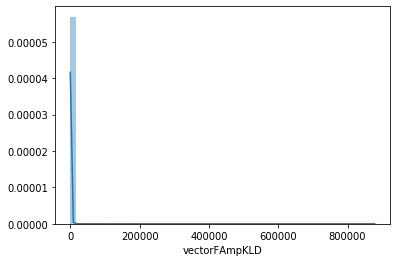

In [45]:
sns.distplot(df_2['vectorFAmpKLD']) # 300

### vectorCorrKLD 
> threshold 100, 50, 10 ≈ 99 %

> threshold 2 ≈ 98 %

In [8]:
threshold = 2

In [9]:
df_2 = df_1.copy()
z = np.abs(st.zscore(df_2['vectorCorrKLD']))
print(max( z ))
print(np.where(z > threshold))

594.34607
(array([  203093,   203094,   203095, ..., 81261863, 81261864, 81261865]),)


In [10]:
df_2 = df_2[(z <= threshold)]
print(df_1.shape)
print(df_2.shape)
print(100*df_2.shape[0]/df_1.shape[0])

(81320065, 4)
(80215488, 4)
98.64169193667024


> BEFORE / AFTER

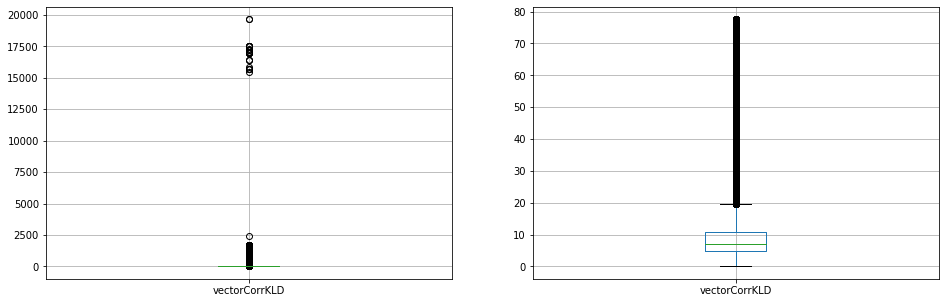

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5)) # 300
df_ALL.boxplot(column='vectorCorrKLD', ax=ax[0])
df_2.boxplot(column='vectorCorrKLD', ax=ax[1])
plt.show(); fig.clf(); plt.close()

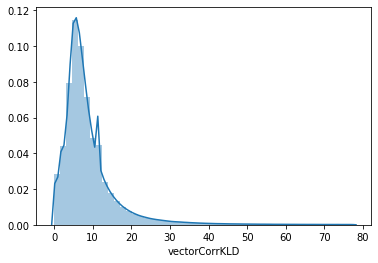

In [12]:
sns.distplot(df_2['vectorCorrKLD']) # 300

## RECAP, Remove outliers

> 1° with the Z Score, 2° the others

In [13]:
df_1 = df_ALL
df_2 = df_1.copy()

In [14]:
zCorrKLD = np.abs(st.zscore(df_1['vectorCorrKLD']))
zFAmpKLD = np.abs(st.zscore(df_1['vectorFAmpKLD']))

In [15]:
threshold = 20
toMaintain_CorrKLD = zCorrKLD <= threshold
toMaintain_FAmpKLD = zFAmpKLD <= threshold
toMaintain = np.logical_and(toMaintain_CorrKLD, toMaintain_FAmpKLD) # boolan array

In [16]:
df_2 = df_2[toMaintain]
print(df_2.shape)

(50328609, 4)


In [17]:
df_3 = df_2.copy()

In [18]:
df_3 = df_2[(df_2['vectorUFAmpKLD'] < 2e+10)]
df_3 = df_3[(df_3['vectorRRKLD'] < 0.5e+10)]
print(df_3.shape)

(50320227, 4)


> get rid of unuserd variables

In [19]:
df_nout = df_3.copy()
del toMaintain_CorrKLD, toMaintain_FAmpKLD, toMaintain, zCorrKLD, zFAmpKLD, df_1, df_2, df_3
gc.collect()

14

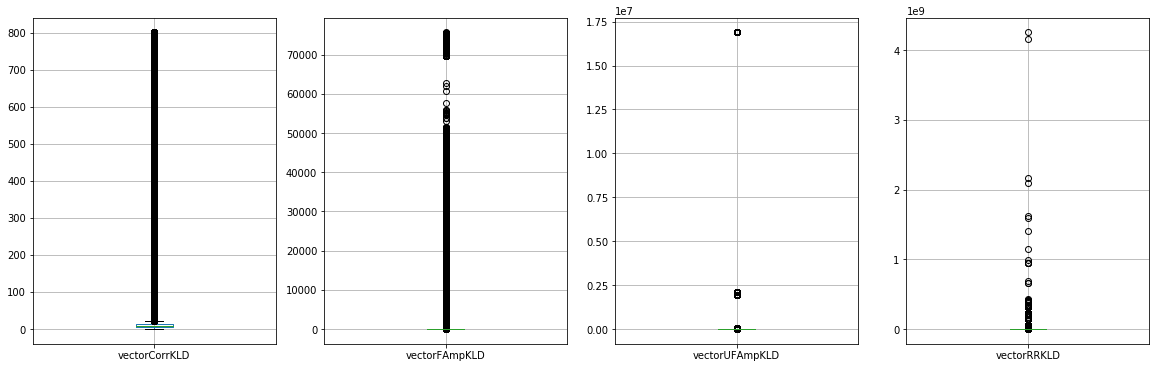

In [20]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6))
df_nout.boxplot(column='vectorCorrKLD', ax=ax[0])
df_nout.boxplot(column='vectorFAmpKLD', ax=ax[1])
df_nout.boxplot(column='vectorUFAmpKLD', ax=ax[2])
df_nout.boxplot(column='vectorRRKLD', ax=ax[3])
plt.show()
fig.clf()
plt.close()

In [ ]:
np.where(zFAmpKLD <= threshold)

In [ ]:
percentage_to_maintain = 0.99
label = 'vectorUFAmpKLD'
math.floor( df_1[label].shape[0] * percentage_to_maintain )

In [14]:
dfs = df_1.sort_values(by=label)

In [15]:
dfs

,vectorRRKLD,vectorFAmpKLD,vectorUFAmpKLD,vectorCorrKLD
14239790,6.630342e+00,2.599939,-1.520206e+00,1.079733
14239789,6.573077e+00,2.608436,-1.498417e+00,1.110019
14239788,6.573077e+00,2.608436,-1.498417e+00,1.110019
14239787,6.551005e+00,2.638307,-1.468318e+00,1.169989
14239786,6.551005e+00,2.638307,-1.468318e+00,1.169989
14239785,6.578772e+00,2.554001,-1.395731e+00,1.158270
14239791,6.705580e+00,2.435985,-1.327465e+00,1.108520
14239792,6.749278e+00,2.631423,-1.318953e+00,1.312470
14239779,6.239830e+00,2.704632,-1.236722e+00,1.467910
14239778,6.246092e+00,2.553950,-1.235644e+00,1.318306


In [21]:
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier, NearestNeighbors

In [22]:
neigh = LocalOutlierFactor(n_neighbors=2)

In [26]:
X = df_nout.to_numpy()

In [27]:

X.shape

(50320227, 4)

In [28]:
X_UFAMP = X[:,2]

In [29]:
X_UFAMP.shape

(50320227,)

In [30]:
X_UFAMP = X_UFAMP.reshape((X_UFAMP.shape[0],1))

In [31]:
X_UFAMP.shape

(50320227, 1)

In [32]:
X_UFAMP[0]

array([5.01015], dtype=float32)

In [33]:
X_UFAMP = np.insert(X_UFAMP, 1, 0, axis=1)

In [34]:
X_UFAMP.shape

(50320227, 2)

In [35]:
X_UFAMP

array([[ 5.01015 ,  0.      ],
       [ 4.936006,  0.      ],
       [ 5.059862,  0.      ],
       ...,
       [43.095245,  0.      ],
       [42.66961 ,  0.      ],
       [46.24449 ,  0.      ]], dtype=float32)

In [36]:
neigh.fit(X_UFAMP)

/homes/v18porti/.local/lib/python3.6/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


LocalOutlierFactor(algorithm='auto', contamination='legacy', leaf_size=30,
                   metric='minkowski', metric_params=None, n_jobs=None,
                   n_neighbors=2, novelty=False, p=2)

In [37]:
Y = neigh.fit_predict(X_UFAMP)#.predict(X)

/homes/v18porti/.local/lib/python3.6/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


In [38]:
Y.shape

(50320227,)

In [39]:
sum(Y)

43216445

In [40]:
np.unique(Y)

array([-1,  1])

In [47]:
df_2 = df_nout.copy()
df_2 = df_nout[(Y == 1)]
print(df_nout.shape)
print(df_2.shape)

(50320227, 4)
(46768336, 4)


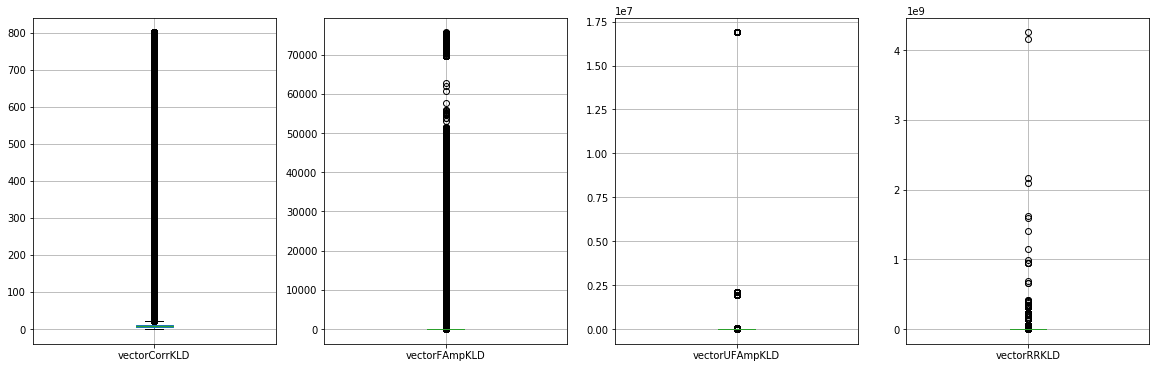

In [48]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6))
df_2.boxplot(column='vectorCorrKLD', ax=ax[0])
df_2.boxplot(column='vectorFAmpKLD', ax=ax[1])
df_2.boxplot(column='vectorUFAmpKLD', ax=ax[2])
df_2.boxplot(column='vectorRRKLD', ax=ax[3])
plt.show(); fig.clf(); plt.close();

In [43]:
num_attribs = list(df_2)

pipeline = Pipeline([
        ('selector', hp.DataFrameSelector(num_attribs)), # to handle pandas data frame
        ('std_scaler', StandardScaler(copy=True))
    ])

full_pipeline = FeatureUnion(transformer_list=[
    ("main", pipeline),
    ])

X = full_pipeline.fit_transform(df_2)

In [44]:
del df_2, pipeline, full_pipeline
gc.collect()

2936

In [45]:
pca = PCA(n_components=0.95)
pca.fit(X)  
print(pca.explained_variance_ratio_) 
print(pca.singular_values_)
print(pca.components_)

[0.260345   0.25697971 0.24277369 0.2399016 ]
[6978.798  6933.5464 6739.1763 6699.1943]
[[ 0.34035164  0.6100651   0.5536263   0.4532982 ]
 [ 0.6249988  -0.35582703 -0.4354442   0.54143524]
 [ 0.6072527  -0.337668    0.45487782 -0.55705583]
 [ 0.35324448  0.6222446  -0.5449519  -0.43710154]]


In [30]:
X = pca.transform(X).astype(np.float32)

In [31]:
principalDf = pd.DataFrame(data=X, columns=['pc1', 'pc2'])

In [32]:
principalDf.info()
del pca
gc.collect()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46798282 entries, 0 to 46798281
Data columns (total 2 columns):
pc1    float32
pc2    float32
dtypes: float32(2)
memory usage: 357.0 MB


0

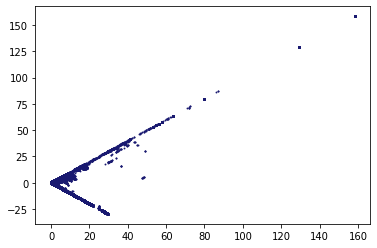

In [33]:
plt.scatter(principalDf['pc1'], principalDf['pc2'],  s=0.8, c='midnightblue')
plt.show(); plt.clf(); plt.close();

In [64]:
Z = neigh.predict(X_UFAMP)#.predict(X)

AttributeError: predict is not available when novelty=False, use fit_predict if you want to predict on training data. Use novelty=True if you want to use LOF for novelty detection and predict on new unseen data.

In [ ]:
Z.shape

In [ ]:
sum(Z)

In [ ]:
np.unique(Z)

In [ ]:
stat, p = st.normaltest(X)

In [ ]:
#https://www.analyticsvidhya.com/blog/2019/02/outlier-detection-python-pyod/
"""classifiers = {
     'Histogram-based Outlier Detection (HBOS)'   : HBOS(),
}"""

In [ ]:
"""for i, (clf_name, clf) in enumerate(classifiers.items()) :
    clf.fit(X)"""

# NEXT TIME

In [13]:
from pyod.models.hbos import HBOS

/homes/v18porti/.local/lib/python3.6/site-packages/numba/errors.py:131: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [7]:
X_UFAMP = X[:,2]

In [8]:
df_ALL.head()

,vectorRRKLD,vectorFAmpKLD,vectorUFAmpKLD,vectorCorrKLD
0,14.824769,3.782338,5.010150,0.155980
1,15.162229,3.555532,4.936006,0.182778
2,15.026611,3.573871,5.059862,0.182778
3,14.735096,3.568545,5.038576,0.182777
4,14.735096,3.568545,5.038576,0.182777


In [9]:
X_UFAMP.shape

(50359472,)

In [10]:
X_UFAMP = X_UFAMP.reshape(-1, 1) #X_UFAMP = X_UFAMP.reshape((X_UFAMP.shape[0],1))

In [11]:
X_UFAMP = np.insert(X_UFAMP, 1, 0, axis=1)

In [12]:
X_UFAMP

array([[ 5.01015 ,  0.      ],
       [ 4.936006,  0.      ],
       [ 5.059862,  0.      ],
       ...,
       [43.095245,  0.      ],
       [42.66961 ,  0.      ],
       [46.24449 ,  0.      ]], dtype=float32)

In [14]:
clf = HBOS()
clf.fit(X_UFAMP)

HBOS(alpha=0.1, contamination=0.1, n_bins=10, tol=0.5)

In [15]:
scores_pred = clf.decision_function(X_UFAMP)*-1

In [16]:
y_pred = clf.predict(X_UFAMP)

In [17]:
y_pred.shape

(50359472,)

In [18]:
sum(y_pred)

0

In [19]:
np.unique(y_pred)

array([0])

(50359472, 4)
(50005387, 4)


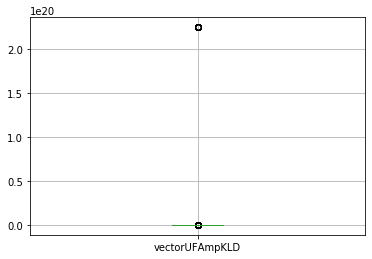

In [22]:
df_2 = df_1.copy()
df_2 = df_1[(y_pred == 0)]
print(df_1.shape)
print(df_2.shape)
df_2.boxplot('vectorUFAmpKLD')

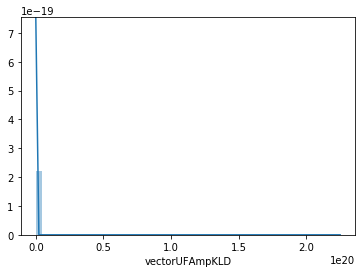

In [23]:
sns.distplot(df_2['vectorUFAmpKLD'])

In [22]:
from pyod.models.knn import KNN

In [23]:
clf = KNN()
clf.fit(X_UFAMP)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [24]:
scores_pred = clf.decision_function(X)*-1

ValueError: query data dimension must match training data dimension

In [ ]:
y_pred = clf.predict(X)

In [ ]:
sum(y_pred)

In [ ]:
np.unique(y_pred)

In [ ]:
df_2 = df_1.copy()
df_2 = df_1[(y_pred == 0)]
print(df_1.shape)
print(df_2.shape)
df_2.boxplot('vectorUFAmpKLD')

### ------------------------------ START --------------------------------------

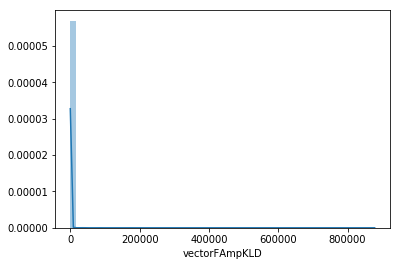

In [10]:
sns.distplot(df_ALL['vectorFAmpKLD']) # 200

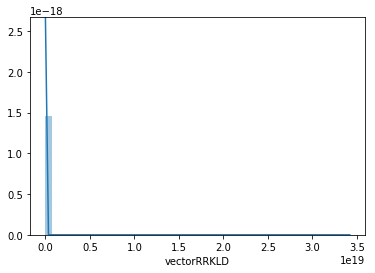

In [11]:
sns.distplot(df_ALL['vectorRRKLD']) # 200

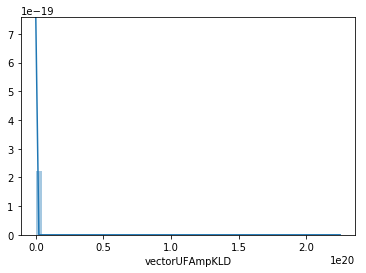

In [12]:
sns.distplot(df_ALL['vectorUFAmpKLD']) # 200

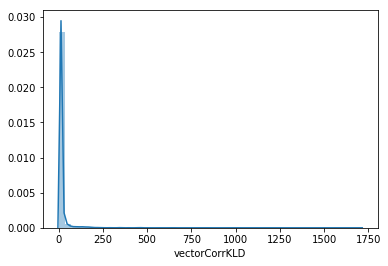

In [ ]:
sns.distplot(df_ALL['vectorCorrKLD']) # 200

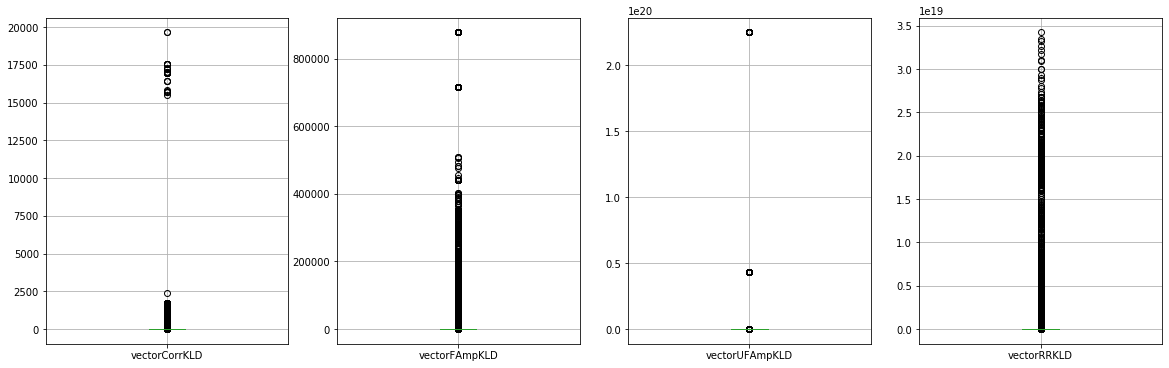

In [17]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6)) # 300
df_ALL.boxplot(column='vectorCorrKLD', ax=ax[0])
df_ALL.boxplot(column='vectorFAmpKLD', ax=ax[1])
df_ALL.boxplot(column='vectorUFAmpKLD', ax=ax[2])
df_ALL.boxplot(column='vectorRRKLD', ax=ax[3])
plt.show()
fig.clf()
plt.close()